# Лабораторная работа №4
## Фотоакустическая томография
### Метод обращения времени для двумерного волнового уравнения

---

## Цель работы

1. Численно реализовать прямую задачу для двумерного волнового уравнения.
2. Реализовать обратную задачу методом обращения времени.
3. Восстановить носитель функции f по граничным измерениям.
4. Проанализировать корректность восстановления.


## Постановка задачи

Формулы приведены в точной записи как в исходной методичке.


### Прямая задача

Рассматривается уравнение

$$
\frac{1}{c^2} u_{tt} = u_{xx} + u_{yy} \qquad \Omega \times [0; T]
$$

Начальные условия:

$$
u_t|_{t=0} = 0 \qquad u|_{t=0} = f
$$

Граничное условие:

$$
u_n|_{\partial \Omega \times [0;T]} = 0
$$

где $u_n$ — производная по нормали, а функция $f$ имеет компактный носитель.

Решение прямой задачи обозначается через $u^f$.


### Обратная задача

Требуется определить $\mathrm{supp}\, f$ по данным наблюдений

$$
u^f|_{\partial \Omega \times [0;T]}
$$

(время наблюдения $T$ должно быть достаточно большим).

Для решения обратной задачи рассматривается начально-краевая задача

$$
v_{tt} = \Delta v \qquad \Omega \times [0; T]
$$

с условиями

$$
v_t|_{t=T} = 0 \qquad v|_{t=T} = 0
$$

и граничным условием

$$
v|_{\partial \Omega \times [0;T]} = u^f
$$


# Явная конечно-разностная схема (Explicit finite difference schemes)

Для прямой задачи:

$$
\frac{u^{i+1}_{j;k} - 2u^i_{j;k} + u^{i-1}_{j;k}}{c^2 \tau^2}
=
\frac{u^i_{j+1;k} - 2u^i_{j;k} + u^i_{j-1;k}}{h^2}
+
\frac{u^i_{j;k+1} - 2u^i_{j;k} + u^i_{j;k-1}}{h^2}
$$

где

$$
h = \Delta x = \Delta y \qquad \tau = \Delta t
$$

Начальные данные:

$$
u^0_{j;k} = f_{j;k} \qquad u^1_{j;k} = f_{j;k}
$$

Схема является условно устойчивой при выполнении условия Куранта:

$$
c\tau < h;
$$

Пусть

$$
\Omega = [0, l] \times [0, l]
$$

Тогда

$$
u_n|_{x=0} = -u_x(0,y,t) \quad u_n|_{x=l}=u_x(l,y,t)
$$

$$
u_n|_{y=0} = -u_x(x,0,t) \quad u_n|_{y=l}=u_x(x,l,t)
$$

Когда $ x_j $ или $ y_k $ это координаты граничных узлов, разностная схема должна быть изменена в соответствии с условиями Неймана. Для граничных узлов используем условия Неймана:

$$ u_x(0, y_k, t_i) = \frac{u(h,y_k,t_i)-u(-h,y_k,t_i)}{2h} = 0 $$
$$ u_x(l, y_k, t_i) = \frac{u(l+h,y_k,t_i)-u(l-h,y_k,t_i)}{2h} = 0 $$
$$ u_y(x_j, 0, t_i) = \frac{u(x_j,h,t_i)-u(x_j,-h,t_i)}{2h} = 0 $$
$$ u_y(x_j, l, t_i) = \frac{u(x_j,l+h,t_i)-u(x_j,l-h,t_i)}{2h} = 0 $$

В численной схеме с обращенным временем

$$
\frac{v^{i+1}_{j;k} - 2v^i_{j;k} + v^{i-1}_{j;k}}{c^2 \tau^2}
=
\frac{v^i_{j+1;k} - 2v^i_{j;k} + v^i_{j-1;k}}{h^2}
+
\frac{v^i_{j;k+1} - 2v^i_{j;k} + v^i_{j;k-1}}{h^2}
$$

включены только внутренние узлы

##  Теоретическое обоснование

### Обратимость волнового уравнения

Волновое уравнение является гиперболическим и обладает свойством обратимости по времени. Если u(x,y,t) является решением, то функция u(x,y,T-t) также удовлетворяет волновому уравнению.

###  Распространение сингулярностей

Особенности (границы носителя функции f) распространяются вдоль характеристик со скоростью c. Таким образом, информация о геометрии источника кодируется в фронтах волны.

###  Метод обращения времени

Если на границе известны значения решения во времени, то при решении уравнения назад по времени волновая энергия фокусируется обратно в область первоначального источника.

Даже при выборе нулевых конечных условий v(T)=0 и v_t(T)=0 геометрия носителя восстанавливается, поскольку граничные данные содержат информацию о фронтах волны.

Амплитуды могут искажаться, однако support определяется устойчиво.


## Численная реализация

In [1]:

import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Параметры задачи
c = 1.0          # скорость волны
L = 1.0          # размер области
Nx = 100         # число узлов по x
Ny = 100         # число узлов по y
T = 1.2         # конечное время
Nt = 500         # число временных шагов

h = L / Nx
tau = T / Nt

# Проверка условия Куранта
assert c * tau < h

x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)


In [3]:

# Задаём функцию с компактным несвязным носителем (две окружности)

def f(x, y):
    circle1 = ((x-0.3)**2 + (y-0.3)**2) < 0.01
    circle2 = ((x-0.7)**2 + (y-0.7)**2) < 0.02
    return circle1.astype(float) + circle2.astype(float)

u_prev = f(X, Y)
u = u_prev.copy()
u_next = np.zeros_like(u)

# Хранилище граничных данных во времени
boundary_data = []


In [4]:

# Прямая задача — распространение волны

for n in range(1, Nt-1):

    # Сохраняем текущие граничные данные
    boundary_snapshot = np.zeros_like(u)
    boundary_snapshot[0,:]  = u[0,:]
    boundary_snapshot[-1,:] = u[-1,:]
    boundary_snapshot[:,0]  = u[:,0]
    boundary_snapshot[:,-1] = u[:,-1]
    boundary_data.append(boundary_snapshot)

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            u_next[i,j] = (
                2*u[i,j] - u_prev[i,j]
                + c**2 * tau**2 * (
                    (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / h**2 +
                    (u[i,j+1] - 2*u[i,j] + u[i,j-1]) / h**2
                )
            )

    # Неймана
    u_next[0,:]  = u_next[1,:]
    u_next[-1,:] = u_next[-2,:]
    u_next[:,0]  = u_next[:,1]
    u_next[:,-1] = u_next[:,-2]

    u_prev, u = u, u_next.copy()



In [5]:

# Обратная задача
v = np.zeros_like(u)
v_prev = np.zeros_like(u)
v_next = np.zeros_like(u)

# Идём назад по времени
for n in reversed(range(len(boundary_data))):

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            v_next[i,j] = (
                2*v[i,j] - v_prev[i,j]
                + c**2 * tau**2 * (
                    (v[i+1,j] - 2*v[i,j] + v[i-1,j]) / h**2 +
                    (v[i,j+1] - 2*v[i,j] + v[i,j-1]) / h**2
                )
            )

    # Подстановка граничных данных соответствующего времени
    snapshot = boundary_data[n]
    v_next[0,:]  = snapshot[0,:]
    v_next[-1,:] = snapshot[-1,:]
    v_next[:,0]  = snapshot[:,0]
    v_next[:,-1] = snapshot[:,-1]

    v_prev, v = v, v_next.copy()

v0 = v.copy()


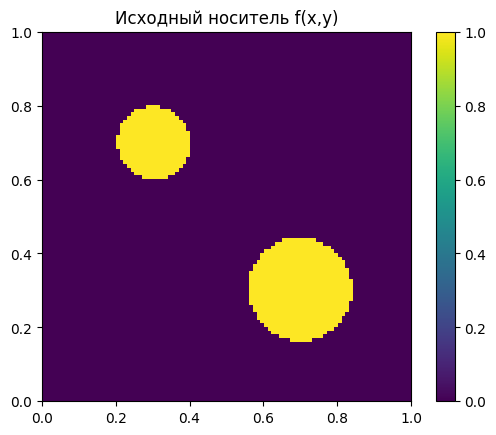

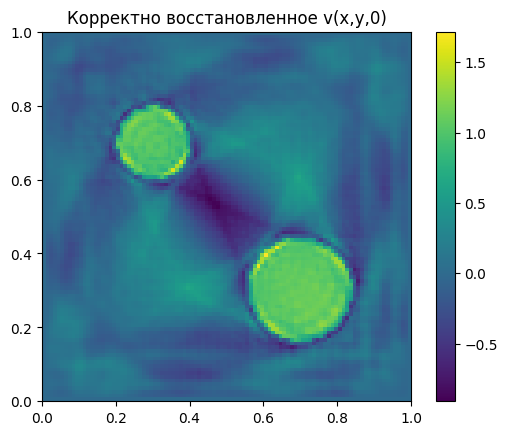

In [6]:

plt.figure()
plt.imshow(f(X,Y), extent=[0,1,0,1])
plt.title("Исходный носитель f(x,y)")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(v0, extent=[0,1,0,1])
plt.title("Корректно восстановленное v(x,y,0)")
plt.colorbar()
plt.show()


##  Выводы

1. Прямая задача для двумерного волнового уравнения корректно реализована явной конечно-разностной схемой второго порядка.
2. Условие Куранта обеспечивает устойчивость численного метода.
3. При реализации метода обращения времени необходимо сохранять граничные данные для всего временного интервала, а не только для конечного момента времени.
4. Использование полного временного сигнала на границе обеспечивает фокусировку волновой энергии в область первоначального источника.
5. Несмотря на нулевые конечные условия, информация о support сохраняется благодаря гиперболической природе уравнения.
